# How To Create Your Own Customized Spotify Playlist 🎵

This code will allow you to make a playlist of songs that you might like from an existing playlist, using a classification model based off a playlist of songs that you like and dislike. 

**It is important to note that the playlists must be public for you to be able to pull data from it.**

# Packages & Libraries 

This is a list of packages and libraries you will need to execute this code. 

In [144]:
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report

from spotipy.oauth2 import SpotifyClientCredentials
import spotipy
import spotipy.util as util
sp = spotipy.Spotify() 

import random

# Getting Started With Your Spotify API

Spotify provides users with a free personal API key that allows you to pull data from your Spotify account, like your playlists. Within those playlists you can pull audio features about those songs like their danceability, energy, loudness, etc.

In order to obtain your personal API keys, you must first create an account at
Spotify for Deleveopers using the following 
link: https://developer.spotify.com/

After creating an account, you will be given a Client ID and a Client Secret ID, which will be used in the code below to both access and authenticate your account. 

In [145]:
client_id = "4b15fcc288d3420abde032fde2e986ef" 
client_secret = "6858e0e37841416684238be3c8d09e35" 

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) # Spotify object to access API

After accessing your specific Spotify account through the API keys, you can now successfully look at songs, playlists, etc. from Spotify.

So the next step of the project will consist of pulling data from your very own spotify playlists. You will, of course, want to use a playlist consisting of only songs that you like, dislike, and want to search through.

Once you've found a playlist that you like, dislike, and search through, you will need the following two items: user_ID and playlist_ID. These can both be found using the URLs as shown below for reference.

https://open.spotify.com/playlist/{playlist_ID}

https://open.spotify.com/user/{user_ID}

Create DataFrame 1 - Playlist IDs and Names:

After getting the two IDs, you can use the function below, which will extract information such as names, IDs, and popularity from songs within the playlist to create a data frame. There are numerous other song characteristics to choose from, so you can access other traits using:

https://spotipy.readthedocs.io/en/latest/

In [146]:
def playlist_trackID(user_ID,playlist_ID):
    """
    This function will take a playlist ID and a user's ID and return a Pandas DataFrame of the song's features within that playlist 
    """
    track_id = []
    popularity = []
    artist_name = []
    track_name = []
    playlist = sp.user_playlist_tracks(user_ID,playlist_ID)
    for song in playlist['items']:
        track = song['track']
        track_id.append(track['id'])
        popularity.append(track['popularity'])
        track_name.append(track['name'])
        artist_name.append(track['artists'][0]['name'])
    return pd.DataFrame({'artist_name':artist_name,'track_name':track_name,'track_id':track_id,'popularity':popularity})

Create DataFrame 2 - Playlist Audio Features:

After pulling more of the general information about the songs on the playlists, you will need to use Spotify's sp.audio_features() to grab even more characteristics about the songs such as energy, loudness, etc. into another separate dataframe. The full list of audio features can be found here: 
https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/. 

In [147]:
def get_audio_features(dataframe_name):
    """
    Pulling all of the audio features of a song into a list and then into a dataframe
    """
    afeatures = []
    number = len(dataframe_name)
    for i in range(0,len(dataframe_name['track_id']),number):
        batch = dataframe_name['track_id'][i:i+number]
        audio_features = sp.audio_features(batch)
        for i, t in enumerate(audio_features):
            afeatures.append(t)
    return pd.DataFrame.from_dict(afeatures,orient='columns')

Merging DataFrames:
 
Now that you have the audio features as well as artist name and track name and ID of each song in your playlist, you will need to merge the two dataframes. After merging, you will also want to remove some of the unnecessary columns that will not be very useful for the predictive model.

The merge of the dataframes must be made on a shared variable, using inner join. That variable would be track_id and id. You need to rename the variable name again as Python is case sensitive.

In [148]:
def merge_dataframes(dataframe1,dataframe2):
    drop_columns = ['analysis_url','track_href','type']
    dataframe2.drop(drop_columns,axis=1,inplace=True)
    dataframe2.rename(columns={'id': 'track_id'}, inplace=True)
    return pd.merge(dataframe1,dataframe2,on='track_id',how='inner')

In [149]:
first_dataframe_user = playlist_trackID('lookitschibbles','2A0U5kbrxeN4zNcCiU1eyM')
second_dataframe_user = get_audio_features(first_dataframe_user)
final_dataframe_user = merge_dataframes(first_dataframe_user,second_dataframe_user)
final_dataframe_user.to_csv('Bad_Spotify.csv')

Using the user's ID and playlist ID we can create CSV files of their selected playlists that include the track ID, track name, and audio features. You will need a "bad" playlist, a list of songs that you dislike, and a "good" playlist, a list of songs that you do like, as well as a playlist you want to search through to pull songs from to make your customized playlist. 

# Data Pre-Processing

In this section we will explore the characteristics of the two playlists and songs within, using correlation maps and histograms. 

Now that we have our CSV files for our "good" and "bad" playlist from the section above, we need to add "targets" so that we can distinguish between the songs that we like and the songs that we dislike. We have used 1 to distinguish songs that we like and 0 to distinguish that songs that we dislike.   

In [150]:
def good_playlist(good_playlist_csv):
    """
    Making a new column in the data frame called 'Target' that classifies the songs you like as 1
    good: playlist of songs that you like 
    """
    good = pd.read_csv(good_playlist_csv)
    target = 1
    good['target'] = target
    return good
good_playlist('Jin_Spotify.csv')

,Unnamed: 0,artist_name,track_name,track_id,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,uri,duration_ms,time_signature,target
0,0,Imagine Dragons,It's Time,6BtmXhTJMM9sBTHeYYASGz,67,0.656,0.884,2,-4.748,1,0.0372,0.0162,0.000000,0.1450,0.860,105.009,spotify:track:6BtmXhTJMM9sBTHeYYASGz,237987,4,1
1,1,Imagine Dragons,Radioactive,4G8gkOterJn0Ywt6uhqbhp,73,0.448,0.784,9,-3.686,1,0.0627,0.1060,0.000108,0.6680,0.236,136.245,spotify:track:4G8gkOterJn0Ywt6uhqbhp,186813,4,1
2,2,Imagine Dragons,On Top Of The World,6Qj1WXW41Mn3Fh9V2sHphM,58,0.635,0.926,0,-5.589,1,0.1510,0.0893,0.000005,0.0928,0.761,100.048,spotify:track:6Qj1WXW41Mn3Fh9V2sHphM,189840,4,1
3,3,Phillip Phillips,"Gone, Gone, Gone",20S0KRq4z2v2Utym0C246s,46,0.664,0.642,6,-5.961,1,0.0380,0.1290,0.000000,0.1140,0.501,118.002,spotify:track:20S0KRq4z2v2Utym0C246s,209693,4,1
4,4,Phillip Phillips,Home,2ZQyksYO4zzhyHNcueL0CP,19,0.592,0.792,0,-5.884,1,0.0335,0.0215,0.000000,0.1590,0.293,121.001,spotify:track:2ZQyksYO4zzhyHNcueL0CP,209227,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,Band of Horses,The Funeral,4o0NjemqhmsYLIMwlcosvW,17,0.316,0.769,0,-5.283,0,0.0422,0.0142,0.000000,0.0928,0.127,122.507,spotify:track:4o0NjemqhmsYLIMwlcosvW,321147,4,1
96,96,Band of Horses,Is There A Ghost,5qWgGPylB0Al9IVq2HKTHE,5,0.300,0.843,1,-3.841,1,0.0354,0.0049,0.000005,0.0790,0.139,135.648,spotify:track:5qWgGPylB0Al9IVq2HKTHE,179667,4,1
97,97,Band of Horses,Factory,3wNti9PJJPrP9nF2ccsQvw,45,0.314,0.590,4,-5.865,0,0.0334,0.0300,0.004080,0.1600,0.129,121.186,spotify:track:3wNti9PJJPrP9nF2ccsQvw,275360,4,1
98,98,Band of Horses,Slow Cruel Hands Of Time,3cW5ZF0ANUFuH661wAGUuw,41,0.445,0.393,9,-14.672,1,0.0323,0.3910,0.000003,0.0990,0.197,115.277,spotify:track:3cW5ZF0ANUFuH661wAGUuw,230307,4,1


In [151]:
def bad_playlist(bad_playlist_csv):
    """
    Making a new column in the data frame called 'Target' that classifies the songs you dislike as 0
    bad: playlist of songs that you dislike
    """
    bad = pd.read_csv(bad_playlist_csv)
    target = 0
    bad['target'] = target
    return bad 
bad_playlist('Bad_Spotify.csv')

,Unnamed: 0,artist_name,track_name,track_id,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,uri,duration_ms,time_signature,target
0,0,DEAN,Pour Up,1txxiPalFPdvOlav28ktmZ,0,0.885,0.502,5,-5.619,0,0.0641,0.120000,0.000000,0.1040,0.760,126.979,spotify:track:1txxiPalFPdvOlav28ktmZ,211987,4,0
1,1,DEAN,I'm Not Sorry,7AoK7YuZ5sQYtPofTFElIE,61,0.577,0.751,3,-4.352,0,0.0356,0.000727,0.000000,0.1020,0.506,129.014,spotify:track:7AoK7YuZ5sQYtPofTFElIE,209096,4,0
2,2,DEAN,I Love It,5JL84E1NiOMAZNXhjrtH0W,0,0.429,0.728,5,-3.810,1,0.0597,0.021100,0.000000,0.1520,0.383,125.739,spotify:track:5JL84E1NiOMAZNXhjrtH0W,216957,4,0
3,3,Zico,VENI VIDI VICI,57cF9C0S6cB7SJtTgntkJf,0,0.700,0.929,6,-2.558,1,0.3190,0.057200,0.000000,0.2760,0.759,105.364,spotify:track:57cF9C0S6cB7SJtTgntkJf,193573,4,0
4,4,Zico,Eureka (Feat. Zion.T),2MNv9hlHsQUlxG00IKNxUY,0,0.736,0.806,7,-2.709,1,0.3280,0.029800,0.000000,0.0847,0.763,119.936,spotify:track:2MNv9hlHsQUlxG00IKNxUY,183996,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,Beyoncé,Baby Boy,4WY3HyGXsWqjFRCVD6gnTe,67,0.655,0.488,1,-9.170,1,0.2200,0.082500,0.000001,0.2210,0.791,91.025,spotify:track:4WY3HyGXsWqjFRCVD6gnTe,244827,4,0
96,96,MINO,Fear,5YQ8OVvW80yoZqZ5PK9JXv,47,0.621,0.760,4,-3.241,0,0.2530,0.188000,0.000000,0.1850,0.432,89.842,spotify:track:5YQ8OVvW80yoZqZ5PK9JXv,249318,4,0
97,97,WINNER,BABY BABY,64GiTdVXuZRKTb7fNJXXGc,0,0.536,0.530,0,-6.179,1,0.0403,0.049000,0.000000,0.3370,0.309,179.914,spotify:track:64GiTdVXuZRKTb7fNJXXGc,246253,3,0
98,98,WINNER,SENTIMENTAL,3FTKU4HASDi5n1f1FLOEgY,0,0.775,0.756,7,-5.513,1,0.0580,0.279000,0.000000,0.3990,0.710,118.019,spotify:track:3FTKU4HASDi5n1f1FLOEgY,208264,4,0


We will now create correlation maps for each playlist (our like and dislike playlist), which look at the relationship between the variables (audio features) and if they have high collinearity. If the variables have a high correlation, then we will delete one of the variables. However, if they are not highly correlated, then we keep both. 

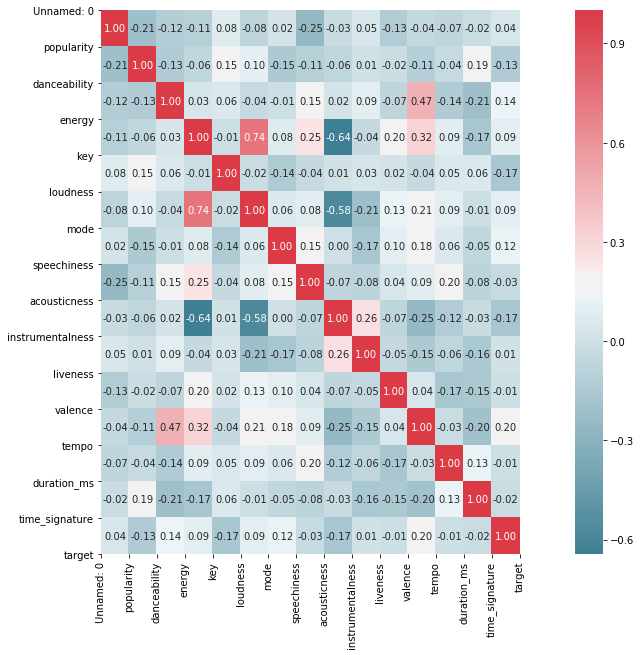

In [152]:
def correlation_map(df):
    """
    creates a correlation map to check for the relationships between variables
    """
    corr = df.corr()
    fig, ax = plt.subplots(figsize = (10,10))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    sns.heatmap(corr, cmap = colormap, annot = True, fmt = '.2f')
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.show()
    
correlation_map(good_playlist("Jin_Spotify.csv"))

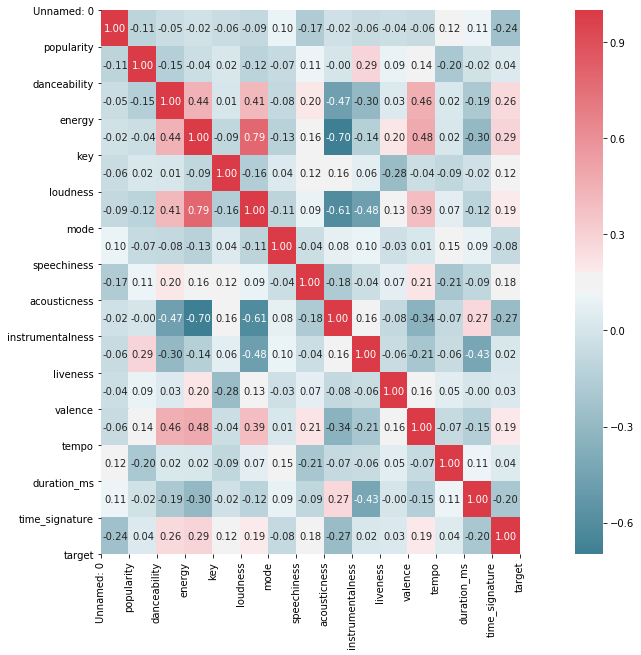

In [153]:
correlation_map(bad_playlist("Bad_Spotify.csv"))

As you can see from our correlation maps for both our liked songs playlist and disliked songs playlist, there is no high correlation between the variables. Therefore, we do not remove any variables. 

Now, we will create histograms that look at the distribution within each audio feature in the playlists. We set alpha as 0.7 so that it was more readable. 

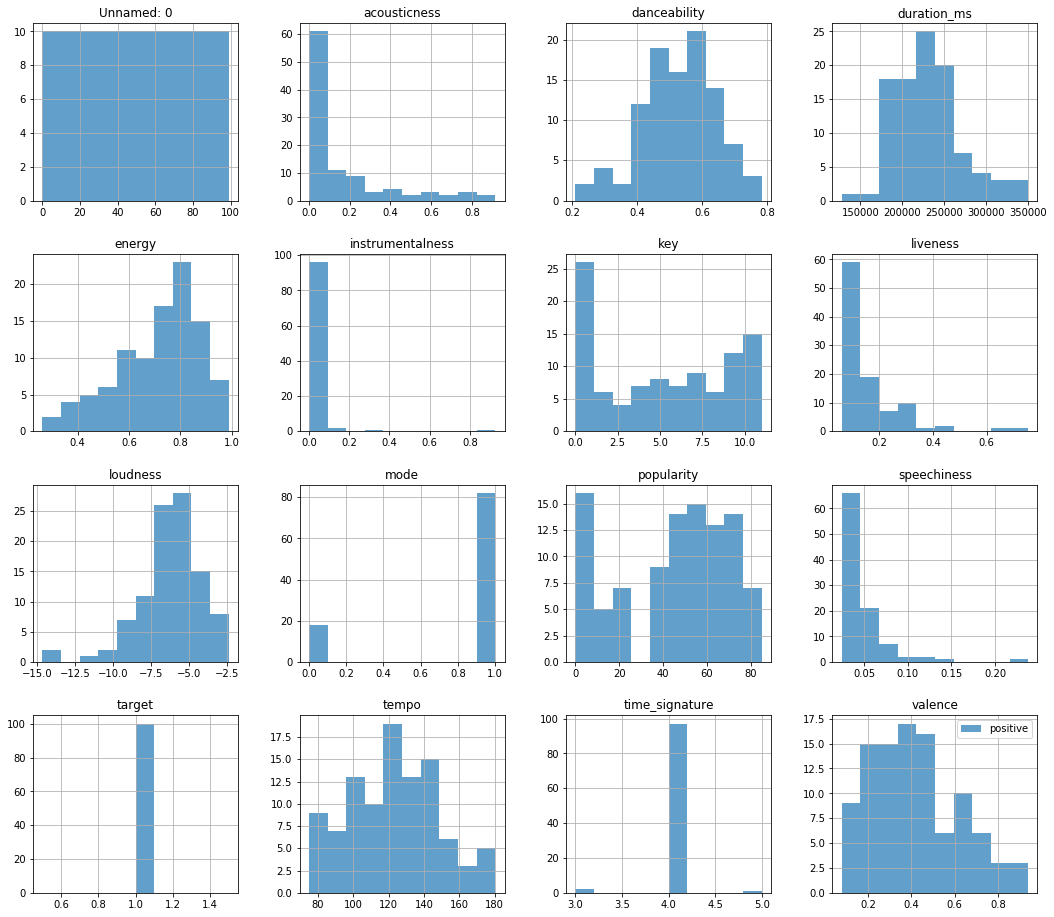

In [154]:
def good_hist(df):
    """
    creating histograms to look at the distribution with audio features
    """
    good = good_playlist(df)
    good.hist(alpha = 0.7, label = 'positive', figsize = (18, 16))
    plt.legend(loc = 'upper right')
    return plt.show()
good_hist('Jin_Spotify.csv')

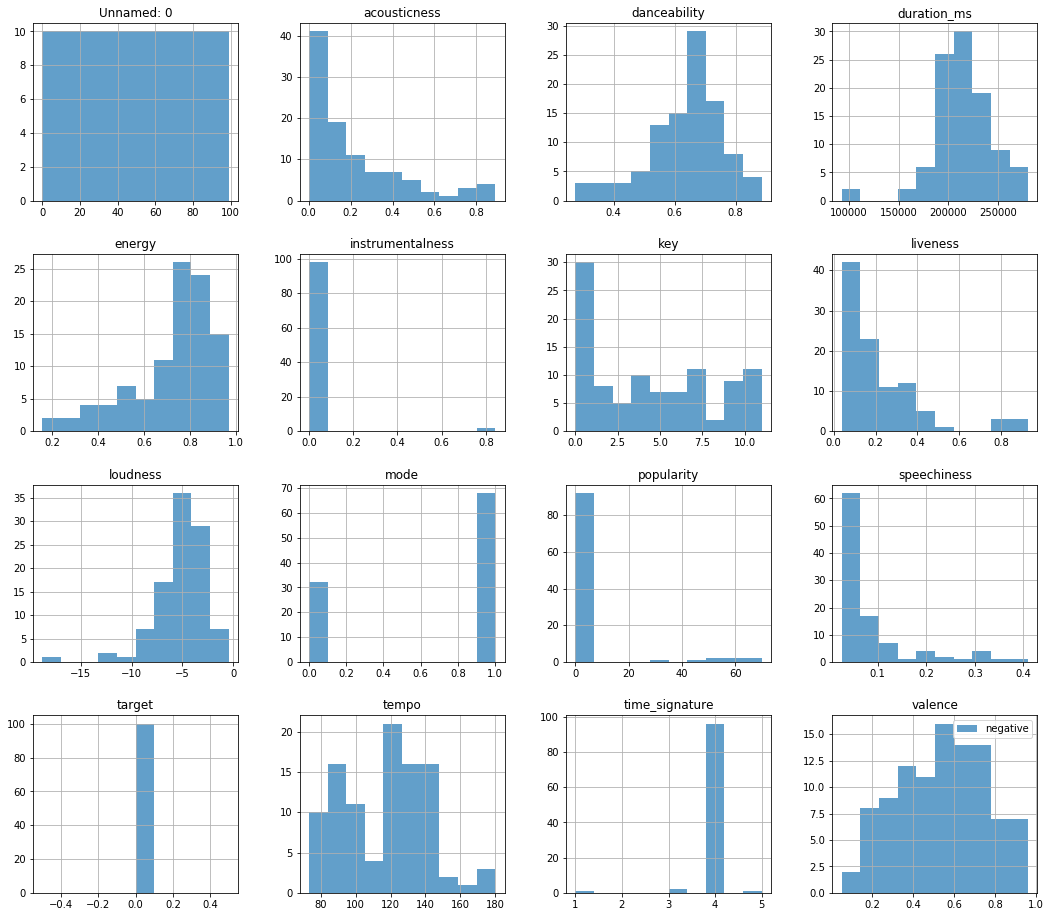

In [155]:
def bad_hist(df):
    bad = bad_playlist(df)
    bad.hist(alpha = 0.7, label = 'negative', figsize = (18, 16))
    plt.legend(loc = 'upper right')
    return plt.show()
bad_hist('Bad_Spotify.csv')

We now need to combine the 2 playlists - liked songs and disliked songs, together into one dataframe so that we can run our prediction models in the next section. 

In [156]:
def one_playlist(df_1, df_2):
    """
    Combining the 'good' and 'bad' playlist into one dataframe
    """
    good = good_playlist(df_1)
    bad = bad_playlist(df_2)
    frames = [good, bad]
    combined = pd.concat(frames, sort = True)
    return combined
df_1 = 'Jin_Spotify.csv'
df_2 = 'Bad_Spotify.csv'
one_playlist(df_1, df_2)

,Unnamed: 0,acousticness,artist_name,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,target,tempo,time_signature,track_id,track_name,uri,valence
0,0,0.0162,Imagine Dragons,0.656,237987,0.884,0.000000,2,0.1450,-4.748,1,67,0.0372,1,105.009,4,6BtmXhTJMM9sBTHeYYASGz,It's Time,spotify:track:6BtmXhTJMM9sBTHeYYASGz,0.860
1,1,0.1060,Imagine Dragons,0.448,186813,0.784,0.000108,9,0.6680,-3.686,1,73,0.0627,1,136.245,4,4G8gkOterJn0Ywt6uhqbhp,Radioactive,spotify:track:4G8gkOterJn0Ywt6uhqbhp,0.236
2,2,0.0893,Imagine Dragons,0.635,189840,0.926,0.000005,0,0.0928,-5.589,1,58,0.1510,1,100.048,4,6Qj1WXW41Mn3Fh9V2sHphM,On Top Of The World,spotify:track:6Qj1WXW41Mn3Fh9V2sHphM,0.761
3,3,0.1290,Phillip Phillips,0.664,209693,0.642,0.000000,6,0.1140,-5.961,1,46,0.0380,1,118.002,4,20S0KRq4z2v2Utym0C246s,"Gone, Gone, Gone",spotify:track:20S0KRq4z2v2Utym0C246s,0.501
4,4,0.0215,Phillip Phillips,0.592,209227,0.792,0.000000,0,0.1590,-5.884,1,19,0.0335,1,121.001,4,2ZQyksYO4zzhyHNcueL0CP,Home,spotify:track:2ZQyksYO4zzhyHNcueL0CP,0.293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.0825,Beyoncé,0.655,244827,0.488,0.000001,1,0.2210,-9.170,1,67,0.2200,0,91.025,4,4WY3HyGXsWqjFRCVD6gnTe,Baby Boy,spotify:track:4WY3HyGXsWqjFRCVD6gnTe,0.791
96,96,0.1880,MINO,0.621,249318,0.760,0.000000,4,0.1850,-3.241,0,47,0.2530,0,89.842,4,5YQ8OVvW80yoZqZ5PK9JXv,Fear,spotify:track:5YQ8OVvW80yoZqZ5PK9JXv,0.432
97,97,0.0490,WINNER,0.536,246253,0.530,0.000000,0,0.3370,-6.179,1,0,0.0403,0,179.914,3,64GiTdVXuZRKTb7fNJXXGc,BABY BABY,spotify:track:64GiTdVXuZRKTb7fNJXXGc,0.309
98,98,0.2790,WINNER,0.775,208264,0.756,0.000000,7,0.3990,-5.513,1,0,0.0580,0,118.019,4,3FTKU4HASDi5n1f1FLOEgY,SENTIMENTAL,spotify:track:3FTKU4HASDi5n1f1FLOEgY,0.710


We need to remove the columns called "unnamed" from the dataframe because we do not need them. We only need the audio features for each song as well as the artist name, song name, and track ID. 

In [157]:
def remove_col(df_1, df_2):
    """
    Deleting the unnecessary columns that label row IDs
    """
    combined = one_playlist(df_1, df_2)
    keep_col = ['artist_name', 'track_name', 'track_id', 'popularity', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'target']
    new_rr = combined[keep_col]
    return new_rr
remove_col(df_1, df_2)

,artist_name,track_name,track_id,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,target
0,Imagine Dragons,It's Time,6BtmXhTJMM9sBTHeYYASGz,67,0.656,0.884,2,-4.748,1,0.0372,0.0162,0.000000,0.1450,0.860,105.009,237987,4,1
1,Imagine Dragons,Radioactive,4G8gkOterJn0Ywt6uhqbhp,73,0.448,0.784,9,-3.686,1,0.0627,0.1060,0.000108,0.6680,0.236,136.245,186813,4,1
2,Imagine Dragons,On Top Of The World,6Qj1WXW41Mn3Fh9V2sHphM,58,0.635,0.926,0,-5.589,1,0.1510,0.0893,0.000005,0.0928,0.761,100.048,189840,4,1
3,Phillip Phillips,"Gone, Gone, Gone",20S0KRq4z2v2Utym0C246s,46,0.664,0.642,6,-5.961,1,0.0380,0.1290,0.000000,0.1140,0.501,118.002,209693,4,1
4,Phillip Phillips,Home,2ZQyksYO4zzhyHNcueL0CP,19,0.592,0.792,0,-5.884,1,0.0335,0.0215,0.000000,0.1590,0.293,121.001,209227,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Beyoncé,Baby Boy,4WY3HyGXsWqjFRCVD6gnTe,67,0.655,0.488,1,-9.170,1,0.2200,0.0825,0.000001,0.2210,0.791,91.025,244827,4,0
96,MINO,Fear,5YQ8OVvW80yoZqZ5PK9JXv,47,0.621,0.760,4,-3.241,0,0.2530,0.1880,0.000000,0.1850,0.432,89.842,249318,4,0
97,WINNER,BABY BABY,64GiTdVXuZRKTb7fNJXXGc,0,0.536,0.530,0,-6.179,1,0.0403,0.0490,0.000000,0.3370,0.309,179.914,246253,3,0
98,WINNER,SENTIMENTAL,3FTKU4HASDi5n1f1FLOEgY,0,0.775,0.756,7,-5.513,1,0.0580,0.2790,0.000000,0.3990,0.710,118.019,208264,4,0


After removing the columns we now have a clean dataframe, which you can see the exmaple above. 


The variables within the dataframe are currently read as objects, however, for us to run our prediction models later on we will need to change them to float. This can be done using the code below. 

In [158]:
def variable_type(df_1, df_2):
    """
    Changing Variable Types from object to numeric values
    """
    variable = ["danceability", "loudness", "valence", "energy", "instrumentalness", "acousticness", "key", "speechiness","duration_ms"]
    for audio_feature in variable:
        new_rr = remove_col(df_1, df_2)
        new_rr[audio_feature] = pd.to_numeric(new_rr[audio_feature], errors = 'coerce')
    return new_rr.dtypes
variable_type(df_1, df_2)

artist_name          object
track_name           object
track_id             object
popularity            int64
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature        int64
target                int64
dtype: object

# Prediction Models

This section of the code will build prediction models using Decision Tree Classification, Random Forest Classifier, and KNN Classifier. The purpose of this section is to see which model will most accurately predict and understand the songs that we like and dislike. 

In [159]:
new_rr = remove_col(df_1, df_2)
random_seed = 5 # set random seed for reproducible results 
variables = ["danceability", "loudness", "valence", "energy", "instrumentalness", "acousticness", "key", "speechiness","duration_ms"]
X = new_rr[variables] # using the variables we would like to use
y = new_rr["target"] # target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_seed) # 80% training and 20% test


In [160]:
def decision_tree():
    # Decision Tree Classification Model
    first_DT_clf = DecisionTreeClassifier() # Decision Tree classifier object
    first_DT_clf = first_DT_clf.fit(X_train, y_train) # train Decision Tree Classifier
    y_pred = first_DT_clf.predict(X_test) # predict the response for the test dataset
    
    # Decision Tree Model Accuracy
    accuracy = (accuracy_score(y_test, y_pred))
    print(f'Accuracy: {accuracy*100}%')
    
    # Decision Tree Classifier Confusion Matrix
    results = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix :')
    print(results)
    print('Report for Decision Tree Model : ')
    print(classification_report(y_test, y_pred))
decision_tree()

Accuracy: 75.0%
Confusion Matrix :
[[13  5]
 [ 5 17]]
Report for Decision Tree Model : 
              precision    recall  f1-score   support

           0       0.72      0.72      0.72        18
           1       0.77      0.77      0.77        22

    accuracy                           0.75        40
   macro avg       0.75      0.75      0.75        40
weighted avg       0.75      0.75      0.75        40



We can see from the results above that the Decision Tree Model has an accuracy of 75%.

In [161]:
def random_forest():
    # Random Forest Tree Model
    RF_CLF = RandomForestClassifier()
    RF_CLF.fit(X_train, y_train)
    RF_pred = RF_CLF.predict(X_test)
    
    # Random Forest Model Accuracy
    accuracy_RF = (accuracy_score(y_test, RF_pred))
    print(f'Accuracy: {accuracy_RF*100}%')
    
    # Random Forest Tree Model Confusion Matrix
    results = confusion_matrix(y_test, RF_pred)
    print('Confusion Matrix :')
    print(results)
    print('Report for Random Forest Model : ')
    print(classification_report(y_test, RF_pred))
random_forest()

Accuracy: 80.0%
Confusion Matrix :
[[15  3]
 [ 5 17]]
Report for Random Forest Model : 
              precision    recall  f1-score   support

           0       0.75      0.83      0.79        18
           1       0.85      0.77      0.81        22

    accuracy                           0.80        40
   macro avg       0.80      0.80      0.80        40
weighted avg       0.81      0.80      0.80        40



C:\Users\cngo1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


We can see from the results above that the Random Forest Model has an accuracy of 85%. 

In [162]:
def knn_model():
    # KNN Model
    knn = KNeighborsClassifier(3)
    knn.fit(X_train, y_train)
    first_DT_clf = DecisionTreeClassifier()
    first_DT_clf = first_DT_clf.fit(X_train, y_train) # train Decision Tree Classifier
    knn_pred = first_DT_clf.predict(X_test)
    
    # KNN Model Accuracy
    score = accuracy_score(y_test, knn_pred)*100
    print(f'Accuracy using KNN Tree: {round(score, 1)}%')
    
    # KNN Confusion Matrix
    results = confusion_matrix(y_test, knn_pred)
    print('Confusion Matrix :')
    print(results)
    print('Report for KNN Model : ')
    print(classification_report(y_test, knn_pred))
knn_model()

Accuracy using KNN Tree: 75.0%
Confusion Matrix :
[[13  5]
 [ 5 17]]
Report for KNN Model : 
              precision    recall  f1-score   support

           0       0.72      0.72      0.72        18
           1       0.77      0.77      0.77        22

    accuracy                           0.75        40
   macro avg       0.75      0.75      0.75        40
weighted avg       0.75      0.75      0.75        40



Finally, we can see from the results above that the the KNN Tree Model has an accuracy of 75%.

After running these three prediction models, we have found that the Random Forest Classifier is the best model to use because of its high accuracy of 85%.

# Predicting Which Songs You Will Like

We know from the prediction models above that the Random Forest Classifier has the highest accuracy, therefore, we have chosen to use it for the below code. 

You can now take a random playlist and the code will pick which songs it thinks you would like to listen to and create a customized playlist for you. 

In [163]:
client_id = "4b15fcc288d3420abde032fde2e986ef"
client_secret = "6858e0e37841416684238be3c8d09e35"
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager) # Spotify object to access API

first_dataframe_spotify = playlist_trackID('spotify','37i9dQZF1DX5IOhx43PGIa')
second_dataframe_spotify = get_audio_features(first_dataframe_spotify)
final_dataframe_spotify = merge_dataframes(first_dataframe_spotify,second_dataframe_spotify)

def recc_songs(daf_1, daf_2, daf_3):
    new_rr = remove_col(daf_1, daf_2)
    random_seed = 5 #set random seed for reproducible results 
    variables = ["danceability", "loudness", "valence", "energy", "instrumentalness", "acousticness", "key", "speechiness","duration_ms"]
    X = new_rr[variables] #using the variables we would like to use 
    y = new_rr["target"] #target variable 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed) # 80% training and 20% test
    RF_CLF = RandomForestClassifier()
    RF_CLF.fit(X_train, y_train)
    pred = RF_CLF.predict(daf_3[variables])
    likedSongs = 0
    i = 0   
    artist_name = []
    track_id = []
    track_name =[]
    track_uri = []
    for prediction in pred:
        if(prediction == 1):
            artist_name.append(daf_3["artist_name"][i])
            track_id.append(daf_3["track_id"][i])
            track_name.append(daf_3["track_name"][i])
            track_uri.append(daf_3["uri"][i])
            # print ("Song: " + final_dataframe_spotify["track_name"][i] + ", By: "+ final_dataframe_spotify["artist_name"][i])
            likedSongs= likedSongs + 1
        i = i +1
    return pd.DataFrame({'artist_name':artist_name,'track_name':track_name,'track_id':track_id,'track_uri':track_uri})

reccy=recc_songs(df_1,df_2,final_dataframe_spotify)
print(reccy)
reccy.to_csv("Reccy.csv")
reccy.csv

          artist_name                                 track_name  \
0               HEIZE                     We don’t talk together   
1                Yuna                                   Does She   
2            88rising                          Midsummer Madness   
3                Joji                                  Sanctuary   
4                Joji                   SLOW DANCING IN THE DARK   
5             No Rome                                  Seventeen   
6             mxmtoon                                 prom dress   
7               KATIE             Remember (feat. Ty Dolla $ign)   
8       Rina Sawayama                     Cherry - Piano Version   
9       Phum Viphurit                                  Lover Boy   
10      Alisson Shore                               Urong Sulong   
11               MISO                                    Take Me   
12      Phum Viphurit                             Hello, Anxiety   
13         Yerin Baek                           

C:\Users\cngo1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


AttributeError: 'DataFrame' object has no attribute 'csv'

In [164]:
from IPython.display import IFrame, HTML

def spotify_player(playlist):
    randomnumber = random.randint(0,56)
    src_id =''
    for track in playlist:
        src_id = playlist['track_id'][randomnumber]
        open_play = "https://open.spotify.com/embed/track/"+src_id
    return IFrame(src=open_play, width = '300', height ='80')
spotify_player(reccy)


# IN PROGRESS

from IPython.display import IFrame, HTML

def spotify_player(playlist):
    src_id = ''
    for track in playlist:
        src_id = playlist['track_uri']
        open_play = "https://open.spotify.com/embed/track/"+src_id
    return IFrame(src=open_play, width="300", height="80")
spotify_player(reccy)

def spotify_player(playlist):
    src_id = ''
    for track in playlist:
        src_id = playlist['track_id'][5]
        open_play = "https://open.spotify.com/embed/track/"+src_id
    return IFrame(src=open_play, width="300", height="80")
spotify_player(reccy)



# References

These are the source codes we used to create our project:

https://towardsdatascience.com/making-your-own-discover-weekly-f1ac7546fedb

https://github.com/nab0310/SpotifyML/blob/master/spotify/Final%20Pretty%20Spotify%20Data%20Classifier.ipynb
